In [1]:
import torch
from torch import nn
import torchvision
import os

# data loader

In [2]:
import torch
from torch import nn
from torchvision import datasets,  transforms
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


import torch
from torch import nn
from torchvision import datasets,  transforms
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

class MyTransform:
    def __init__(self,  hflip=False, vflip=False, rcrop=False, ccrop=False, colorjitter=False, size=None, normalize=True):
        self.size = (size, size)
        self.max_size = 5000
        self.hflip = hflip #random horizontal flip
        self.vflip = vflip
        self.rcrop = rcrop # random crop
        self.ccrop = ccrop # central crop
        self.colorjitter = colorjitter# random colorjitter
        self.color_transform = transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], # hue=0.1
            p=0.8) 
        self.normalize = normalize
    

    def __call__(self, x, y=None):
        if not torch.is_tensor(x):
            x = TF.to_tensor(x)
        if y!=None:
            if not torch.is_tensor(y):
                y = TF.to_tensor(y)
            assert x.shape[-2:]==y.shape[-2:]
        
        if self.size[0]!=None:
            if self.rcrop:
                if x.shape[-2] > self.size[0] and x.shape[-1] > self.size[1]:
                    # resize first to max size
                    #x = TF.resize(x, self.max_size) # original
                    #y = TF.resize(y, self.max_size)
                    
                    top = random.randint(0, x.shape[-2] - self.size[0])
                    left =  random.randint(0, x.shape[-1] - self.size[1] )
                    x = TF.crop(x , top, left, height=self.size[0], width=self.size[1])
                    y = TF.crop(y , top, left, height=self.size[0], width=self.size[1]) if y!=None else None
                else:
                    x = TF.resize(x, self.size)
                    y = TF.resize(y, self.size)  if y!=None else None
            elif self.ccrop:
                x = transforms.CenterCrop(self.size)(x)
                y = transforms.CenterCrop(self.size)(y)  if y!=None else None

            else:
                x = TF.resize(x, self.size) # original
                y = TF.resize(y, self.size)  if y!=None else None
                

        if self.colorjitter:
            x = self.color_transform(x)
            

        if self.hflip:
            rand = random.randint(0,1)
            if rand==1:
                x = TF.hflip(x)
                y = TF.hflip(y)  if y!=None else None

        if self.vflip:
            rand = random.randint(0,1)
            if rand==1:
                x = TF.vflip(x)
                y = TF.vflip(y) if y!=None else None

        if self.normalize:
            x = TF.normalize(x, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        if y!=None:
            return x, y
        return x




In [4]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, mix=False):
        """
        Args:
            image_path (string): Path to the images.
            targets (pd df): labels 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_path = data_path
        self.images_path = data_path + 'images/'
        self.masks_path = data_path + 'masks/'
        self.class_list = ['background', 'cone']
        self.num_cls = len(self.class_list)
        self.images_list = os.listdir(self.images_path) 
        self.masks_list = os.listdir(self.masks_path)
        self.mtype = self.masks_list[0][self.masks_list[0].index('.'):]
        self.itype = self.images_list[0][self.images_list[0].index('.'):]
        self.transform = transform
        self.mix = mix
        self.transform2 = MyTransform(hflip=True, vflip=True, rcrop=True, colorjitter=False, size=transform.size[0], normalize=False)
        
       
        
    def __len__(self):
        return len(self.masks_list)
    
    def __getitem__(self, idx):
        img, target = self.get1item(idx)
        # img [3,h,w], target [c,h,w]
        if self.mix:
            # try augment img size to augment
            [c,h,w]=img.shape
            scale = 1.2
            img2, target2 =  TF.resize(img, size=(int(h*scale),int(w*scale)) ) , TF.resize(target, size=(int(h*scale),int(w*scale)) )
            img2, target2 = self.transform2(img2, target2)
            # don't augment size
            #img2, target2 = self.transform2(img, target)
            m = target2.argmax(0).unsqueeze(0)
            img = img*(1- m.repeat(3,1,1)) + m.repeat(3,1,1)*img2
            #img = img*(1- m.repeat(3,1,1)) + m.repeat(3,1,1)*(img.max() - img)
            target = target*(1-m.repeat(2,1,1)) + m.repeat(2,1,1) * target2
        return img, target.float()
    
            

    def get1item(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if type(idx)==list:
            idx = idx[0]
        mask_name = self.masks_list[idx]
        mask_path = os.path.join( self.masks_path, mask_name)

        img_name = mask_name.split('_')[0]+'.jpg'
        img_path = os.path.join( self.images_path, img_name)
                
        if os.path.isfile(img_path):
            with open(img_path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
        else:
            print(f'ERROR: missing img {img_path}')

        if os.path.isfile(mask_path):
            with open(mask_path, 'rb') as f:
                mask = Image.open(f)
                mask = mask.convert('L') #.convert('RGB')
                
        else:
            print(f'ERROR: missing mask {mask_path}')
        
        if self.transform:
            img, mask = self.transform(img, mask)
        
        c,h,w = img.shape
        target = torch.zeros(self.num_cls, h, w)
        mask = (mask[0]>0)*1
        for i in range(self.num_cls):
            target[i]= (mask==i)*1
        return img, target.float() #.unsqueeze(0).long() # [b,3,h,w], [b,n_cls,h,w]



torch.Size([3, 224, 224]) torch.Size([2, 224, 224])


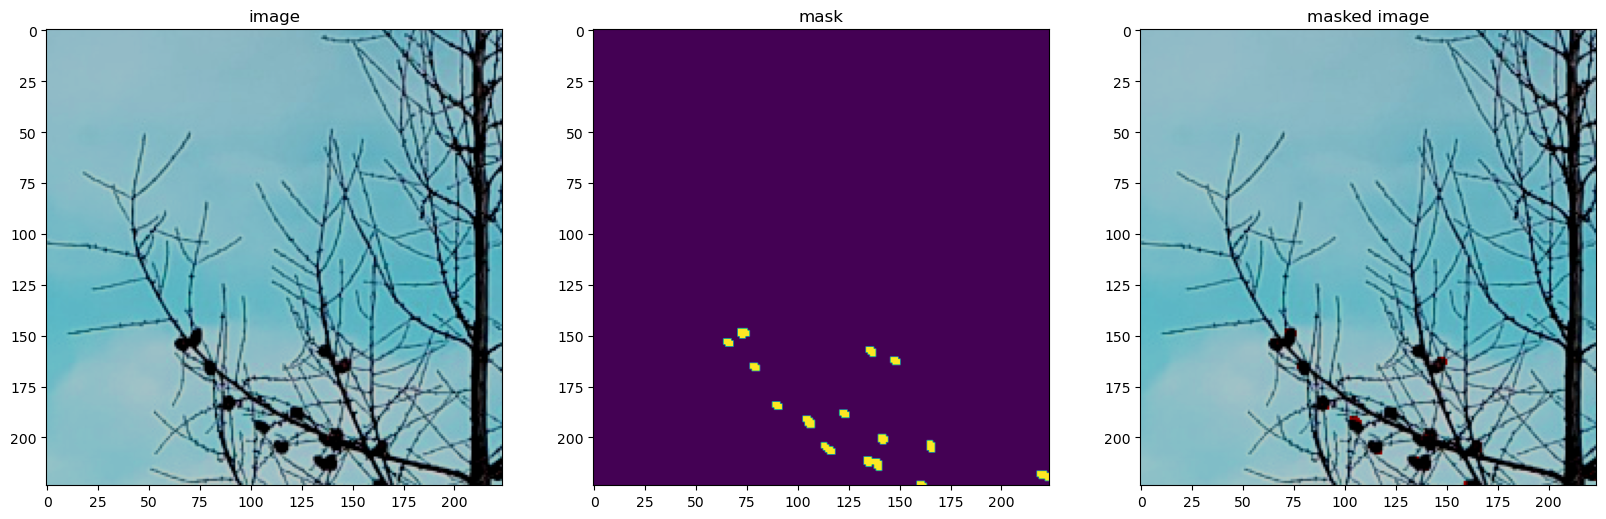

In [5]:
transform = MyTransform(hflip=True, vflip=False, rcrop=True, colorjitter=True, size=224, normalize=False)
dataset = MyDataset( data_path = './datasets/cone/train/', transform=transform, mix=False)

i = torch.randint(0, len(dataset), size=(1,))
inp, target = dataset[i]
mask = target.argmax(0)
print(inp.shape, target.shape )
masked_img = inp.clone()
#masked_img[0]= masked_img[0] * mask * 0 + masked_img[0] * (1-mask)
masked_img[1]= masked_img[1] * mask * 0 + masked_img[1] * (1-mask)
masked_img[2]= masked_img[2] * mask * 0 + masked_img[2] * (1-mask)


fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(1, 3, 1)
ax.title.set_text('image')
plt.imshow(inp.squeeze().permute(1,2,0) )

ax = fig.add_subplot(1, 3, 2)
ax.title.set_text('mask')
plt.imshow(mask.squeeze() )

ax = fig.add_subplot(1, 3, 3)
ax.title.set_text('masked image')
plt.imshow(masked_img.squeeze().permute(1,2,0))

# Model

In [6]:
from model import Segmenter
#model = Segmenter(pretrained_weights='weights/resnet50_miil_21k.pth', image_size=224, num_cls=2 )
model = Segmenter(pretrained_weights='weights/upernet_augreg_adapter_tiny_512_160_ade20k.pth.tar', image_size=512, num_cls=2)

dict_keys(['state_dict'])
Pretrained weights found at weights/upernet_augreg_adapter_tiny_512_160_ade20k.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['pos_embed', 'cls_token', 'level_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.gamma_1', 'blocks.0.gamma_2', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.gamma_1', 'blocks.1.gamma_2', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.gamma_1', 'blocks.2.gamma_2', '

In [7]:
inp = torch.rand(1,3,224,224)
out = model(inp)
print(out.shape)

resize


/home/mp269546/anaconda3/envs/codetr/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/mp269546/anaconda3/envs/codetr/lib/python3.7/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([1, 2, 224, 224])


/home/mp269546/anaconda3/envs/codetr/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


# Predict

In [ ]:
img_transform = transforms.Compose([ transforms.ToTensor(), transforms.Resize( (1024,1024)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

images_path = 'new_images/cone_pictures_NIRR-2022/9/'
images_list =os.listdir(images_path)
img_path = images_path + '95.HEIC' #images_list[0]
img = Image.open(img_path)
inp = img_transform(img)
path_tree='weights/trained/cone/recall_ce.pth'
model_tree = Segmenter(pretrained_weights=path_tree,  image_size=512, max_img_size=512, num_cls=2).eval()
out = model_tree(inp.unsqueeze(0))
plt.figure()
plt.imshow(out.squeeze().argmax(0).detach().numpy() )

dict_keys(['model', 'optimizer', 'epoch', 'args'])
Pretrained weights found at weights/trained/cone/recall_ce.pth and loaded with msg: <All keys matched successfully>
dict_keys(['model', 'optimizer', 'epoch', 'args'])
Pretrained weights found at weights/trained/cone/recall_ce.pth and loaded with msg: <All keys matched successfully>


In [2]:
import numpy
import torch
import pandas
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import  os
import skimage
from skimage.io import imread, imshow
from skimage.feature import  peak_local_max
from model import Segmenter
from torchvision import datasets,  transforms
from PIL import Image
import torchvision.transforms.functional as TF

class Detector:
    def __init__(self, img_dir):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.img_dir =  img_dir
        self.image_size = 512
        path_tree='weights/trained/tree/recall_ce_vflip.pth' #ce_lr0001_adamw.pth' #'recall_ce_lr0001_adamw.pth'
        self.model_tree = Segmenter(  image_size=self.image_size, max_img_size=512, num_cls=2).eval().to(self.device)
        self.load(self.model_tree, path_tree)
        path_cone = 'weights/trained/cone/ce_vflip.pth' #'ce_lr0001_lion.pth'
        self.model_cone = Segmenter(image_size=self.image_size, max_img_size=1024, num_cls=2).eval().to(self.device)
        self.load(self.model_cone, path_cone )
        self.inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
        self.img_transform = transforms.Compose([ transforms.ToTensor(),
                                                 transforms.Resize(1536),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]) # transforms.Resize( (self.image_size, self.image_size)),
        
    
    def postprocess_tree(self, mask):
        [h,w] = mask.shape[2:]
        mask = mask.squeeze(0).argmax(0).numpy() # [H,W]
        
        # label image regions
        mask = (skimage.filters.gaussian(mask, sigma=3, preserve_range=True)>0.5)*1.
        label_mask = skimage.measure.label(mask, background=0, connectivity=2) 
        regions = skimage.measure.regionprops(label_mask )
        mini = max([h,w])
        xmin, ymin, xmax, ymax = 0, 0, h, w
        for region in regions:
            centroid=region.centroid
            distance= numpy.sqrt((centroid[0] - h//2)**2+(centroid[1] - w//2)**2)
            if region.area>0.01*h*w and distance<mini:
                mini=distance
                xmin, ymin, xmax, ymax =region.bbox
        # add margin and set limits
        half = (ymax - ymin)/2
        yc = ymin + half
        ymin = max([0, int(yc-half*1.5 )])
        ymax = min([w, int(yc+half*1.5 )])
        bbox = [xmin, ymin, xmax, ymax]
        return bbox
    
    def postprocess_cones(self, mask):
        mask = mask.squeeze(0).argmax(0).numpy() # [H,W]
        # coordinate with local min
        coordinates =  skimage.feature.peak_local_max( mask, min_distance=3, threshold_abs=0.04)
        return coordinates

    def detect(self, img_name, check=True, a=0.621, b=2.554 ) : #a=1.30 , b=-1.02):
        img_path= os.path.join( self.img_dir, img_name)
        if os.path.isfile(img_path):
            with open(img_path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
        else:
            print(f'ERROR: missing img {img_path}')
        
        inp = self.img_transform(img).unsqueeze(0)
        
        #find central tree
        with torch.no_grad():
            tree_mask = self.model_tree(inp.to(self.device) )
            tree_mask = tree_mask.detach().cpu()
        
        bbox = self.postprocess_tree(tree_mask)
        [xmin, ymin, xmax, ymax] = bbox
        
        # find nb cones
        with torch.no_grad():
            cone_mask = self.model_cone( inp[:, :,  xmin:xmax, ymin:ymax].to(self.device) )
            cone_mask = cone_mask.detach().cpu()
        
        coordinates = self.postprocess_cones(cone_mask)
        coordinates[:,0] = xmin + coordinates[:,0]
        coordinates[:,1] = ymin + coordinates[:,1]
        y_hat = len(coordinates)
        
        
        # linear relationship between 2d predictions and 3d predictions 
        y_hat_3d = int(numpy.exp(b)*y_hat**a)
        if check==True:
            info=[img_name, y_hat, y_hat_3d]
            self.draw(info, inp , bbox, coordinates, tree_mask, width=10)
        return y_hat, y_hat_3d, coordinates, img
    
    def draw(self, info, inp , bbox, coordinates, tree_mask, width=10):
        [img_name, y_hat, y_hat_3d]=info
        [xmin, ymin, xmax, ymax]=bbox
        tree_mask = tree_mask.squeeze().argmax(0)
        mask = torch.zeros(3, tree_mask.shape[0], tree_mask.shape[1])
        mask[2, xmin:xmax, ymin:ymax] = tree_mask[xmin:xmax, ymin:ymax]
        masked_inp = self.inv_normalize(inp.squeeze())
        masked_inp = masked_inp * (1-mask) + mask
        
        fig = plt.figure(figsize=(15,10))

        ax = fig.add_subplot(1, 2, 1)
        ax.title.set_text('original image')
        plt.imshow( self.inv_normalize(inp.squeeze()).permute(1,2,0))
        plt.axis('off')
        
        ax = fig.add_subplot(1, 2, 2)
        ax.title.set_text( f'{img_name} | pred_2d = {y_hat}  | pred_3d = {y_hat_3d}')
        plt.imshow(masked_inp.permute(1,2,0))
        plt.gca().add_patch( Rectangle((ymin,xmin), ymax-ymin, xmax-xmin,  edgecolor='green', facecolor='none', lw=4)) # xy, width, height
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
        plt.axis('off')
        os.makedirs(os.path.join( 'prediction', self.img_dir), exist_ok=True )
        plt.savefig( os.path.join( 'prediction', self.img_dir, img_name).replace('.HEIC', '.jpg') , pad_inches=0.)
        #plt.close()
       

    def run_through_folder(self, img_dir):
        self.img_dir = img_dir
        assert os.path.isdir(img_dir)
        img_list = os.listdir(img_dir)
        data = []
        for img_name in img_list:
            y_hat, y_hat_3d, _, _= self.detect(img_name, check=True)
            print('Image:', img_name, '; pred_2d = ',y_hat, '; pred_3d = ', y_hat_3d)
            data.append([img_name, y_hat, y_hat_3d])
        df = pandas.DataFrame(data, columns=['img_name', 'pred_2d', 'pred_3d'])
        os.makedirs(os.path.join('prediction', img_dir), exist_ok=True )
        df.to_csv(os.path.join('prediction', img_dir, 'prediction.csv'), index=False)
    
    def run_through_folders(self, img_dir):
        for folder in os.listdir(img_dir) :
            print(f'folder {folder}' )
            self.run_through_folder(img_dir+folder)
    
    def load(self, model, pretrained_weights):
        param_dict = torch.load(pretrained_weights, map_location="cpu")
        if 'state_dict' in param_dict.keys():
            param_dict = param_dict['state_dict']
        if 'model' in param_dict.keys():
            param_dict = param_dict['model']
        #param_dict = {k.replace("batch_norm", "bn"): v for k, v in param_dict.items()}
        #param_dict = {k.replace("i_downsample", "downsample"): v for k, v in param_dict.items()}
        
        model_dict = model.state_dict()

        for k in param_dict.keys():
            if k in model_dict.keys():
                p1 = model_dict[k]
                p2 = param_dict[k]
                if p1.shape != p2.shape:
                    print(f'Resize {k} from shape {p2.shape} to {p1.shape}')
                    if p2.ndim==1 or p2.ndim==0:
                        p2 = p2.reshape(1,1,-1)
                        new_shape = p1.shape[0]
                    elif p2.ndim ==2:
                        p2 = p2.permute(1,0).unsqueeze(0)
                        new_shape = p1.shape[1]
                    elif p2.ndim==3:
                        p2 = p2.permute(0,2,1)
                        new_shape = p1.shape[1]
                    p2 = torch.nn.functional.interpolate(p2, size=new_shape, mode='linear')
                    param_dict[k] = p2.permute(0,2,1).squeeze(1).squeeze(2)
        msg = model.load_state_dict(param_dict, strict= False )
        print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))

In [29]:
detect = Detector('new_images/cone_pictures_NIRR-2022/1/')

Pretrained weights found at weights/trained/tree/recall_ce_vflip.pth and loaded with msg: <All keys matched successfully>
Pretrained weights found at weights/trained/cone/ce_vflip.pth and loaded with msg: <All keys matched successfully>


In [ ]:
detect.run_through_folders('new_images/cone_pictures_NIRR-2022/')

folder 20


/home/mp269546/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Image: 49.jpg ; pred_2d =  197 ; pred_3d =  346
Image: 62.jpg ; pred_2d =  148 ; pred_3d =  238
Image: 57.jpg ; pred_2d =  33 ; pred_3d =  33
Image: 78.jpg ; pred_2d =  228 ; pred_3d =  419
Image: 54.jpg ; pred_2d =  584 ; pred_3d =  1423
Image: 77.jpg ; pred_2d =  99 ; pred_3d =  141
Image: 60.jpg ; pred_2d =  198 ; pred_3d =  348
Image: 68.jpg ; pred_2d =  61 ; pred_3d =  75
Image: 95.jpg ; pred_2d =  466 ; pred_3d =  1061
Image: 45.jpg ; pred_2d =  46 ; pred_3d =  52
Image: 47.jpg ; pred_2d =  2889 ; pred_3d =  11376
Image: 93.jpg ; pred_2d =  11 ; pred_3d =  8
Image: 70.jpg ; pred_2d =  121 ; pred_3d =  183
Image: 67.jpg ; pred_2d =  71 ; pred_3d =  91
Image: 65.jpg ; pred_2d =  496 ; pred_3d =  1151
Image: 63.jpg ; pred_2d =  20 ; pred_3d =  17
Image: 50.jpg ; pred_2d =  1246 ; pred_3d =  3812
Image: 53.jpg ; pred_2d =  340 ; pred_3d =  704
Image: 71.jpg ; pred_2d =  13 ; pred_3d =  10
Image: 87.jpg ; pred_2d =  17 ; pred_3d =  14
Image: 73.jpg ; pred_2d =  15 ; pred_3d =  12
Imag

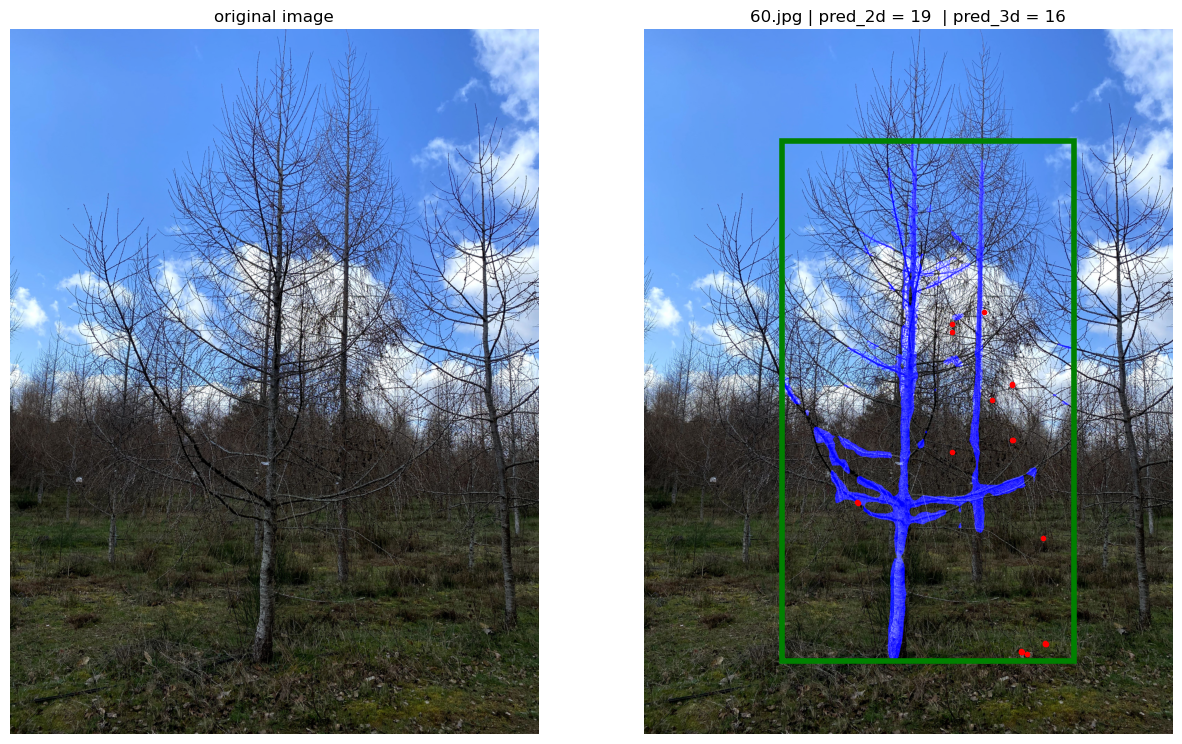

In [31]:
y_hat, y_hat_3d, coordinates, img = detect.detect('60.jpg', check=True)

# Regression pred2d -> pred3d

In [81]:
import sklearn
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

In [82]:
df = pd.read_csv('doc/manual_prediction.csv', delimiter=';')
df

,tree_id,count_img,count_exhaustive
0,1,328,402
1,2,234,352
2,3,52,50
3,4,1443,3108
4,5,420,823
5,6,1751,3209
6,7,1600,3588
7,8,88,132
8,9,26,27
9,10,293,853


In [83]:
my_prediction = pd.read_csv('doc/prediction.csv')
tree_id = [ int( i.replace('tree', '').replace('.jpg','')) for i in my_prediction['img_name']]
my_prediction['tree_id'] = tree_id
my_prediction['pred_2d'] = my_prediction['pred_2d'].replace(0,1)
my_prediction

,img_name,pred_2d,pred_3d,tree_id
0,tree5.jpg,353,739,5
1,tree34.jpg,45,50,34
2,tree8.jpg,16,13,8
3,tree3.jpg,143,228,3
4,tree25.jpg,89,123,25
5,tree31.jpg,406,887,31
6,tree7.jpg,1190,3591,7
7,tree12.jpg,388,836,12
8,tree41.jpg,319,648,41
9,tree35.jpg,7,4,35


In [84]:
df = df.merge(  my_prediction, how='left', on='tree_id' )
df

,tree_id,count_img,count_exhaustive,img_name,pred_2d,pred_3d
0,1,328,402,tree1.jpg,425,941
1,2,234,352,tree2.jpg,821,2216
2,3,52,50,tree3.jpg,143,228
3,4,1443,3108,tree4.jpg,1760,5972
4,5,420,823,tree5.jpg,353,739
5,6,1751,3209,tree6.jpg,446,1002
6,7,1600,3588,tree7.jpg,1190,3591
7,8,88,132,tree8.jpg,16,13
8,9,26,27,tree9.jpg,61,75
9,10,293,853,tree10.jpg,45,50


In [85]:
df = df.drop([33, 43, 10, 11, 24, 25, 32, 34, 38, 47, 5,9,10,18,19,20,21,22,23,28,48,49])
df

,tree_id,count_img,count_exhaustive,img_name,pred_2d,pred_3d
0,1,328,402,tree1.jpg,425,941
1,2,234,352,tree2.jpg,821,2216
2,3,52,50,tree3.jpg,143,228
3,4,1443,3108,tree4.jpg,1760,5972
4,5,420,823,tree5.jpg,353,739
6,7,1600,3588,tree7.jpg,1190,3591
7,8,88,132,tree8.jpg,16,13
8,9,26,27,tree9.jpg,61,75
12,13,203,324,tree13.jpg,288,567
13,14,243,323,tree14.jpg,475,1088


In [86]:
def f(X, a,b):
  out=[]
  for x in X:
    out.append([float(a*x+b)])
  return np.array(out)


manual counting: a= 1.111510884817023  b= -0.05029564492757732 r^2= 0.9523343005418585
deep counting: a= 0.6210131645202637  b= 2.5547494888305664 r^2= 0.5089242810014192


Text(0.5, 0, 'deep counting')

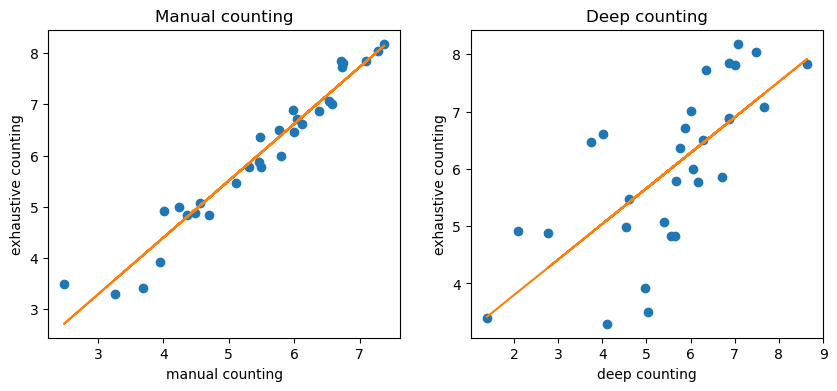

In [90]:
import numpy as np

Z= np.log(np.array(df['count_exhaustive']) ) # target 
Y= np.log( np.array(df['count_img']) )
X= np.log( np.array(df['pred_2d'], dtype=np.float32))
'''
Z=np.array(prediction['count_exhaustive']) # target
Y=np.array(prediction['count_img'])
X=np.reshape(my_prediction, (51, ))
'''
#Z_=np.concatenate((Z[:18], Z[19:32], Z[34:42], Z[43:47], Z[48:]), axis=None) # remove value -1 (index 33 and 43); 3 worst outliers # 19, 32, 48
#Y_=np.concatenate((Y[:18], Y[19:32], Y[34:42], Y[43:47], Y[48:]), axis=None)
#Z__=np.concatenate((Z[:7], Z[8:31], Z[32:47], Z[48:]), axis=None) # remove id 8, 32, 48
#X__=np.concatenate((X[:7], X[8:31], X[32:47], X[48:]), axis=None)

#linear regression
Z_=np.reshape(Z, (len(Z),1) )
Y_=np.reshape(Y, (len(Y), 1) )
reg = LinearRegression().fit( Y_, Z_)
score_y=reg.score(Y_, Z_)
ay, by= float(reg.coef_) , float(reg.intercept_)
print('manual counting: a=', ay, ' b=', by, 'r^2=', score_y)

#linear regression
X__=np.reshape(X, (len(X),1) )
Z__=np.reshape(Z, (len(Z), 1) )
reg = LinearRegression().fit(X__, Z__)
ax, bx= float(reg.coef_) , float(reg.intercept_)
score_x=reg.score(X__, Z__)
print('deep counting: a=', ax, ' b=', bx, 'r^2=', score_x)


fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10, 4))
ax1.plot(Y_, Z_, 'o')
ax1.plot(np.sort(Y_) , f(np.sort(Y_) ,a=ay, b=by))
ax1.set_title('Manual counting'); ax1.set_ylabel('exhaustive counting'); ax1.set_xlabel('manual counting')
ax2.plot(X__,Z__, 'o')
ax2.plot(np.sort(X__), f(np.sort(X__),a=ax, b=bx))
ax2.set_title('Deep counting'); ax2.set_ylabel('exhaustive counting'); ax2.set_xlabel('deep counting')